In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190601

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190605
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190605


In [85]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

# Load dataset as TFRecords 

In [7]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [8]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [9]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

batch_size = 16

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=8,
                                         shuffle_buffer_size=128,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         perform_data_augmentation=False)

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=8,
                                          shuffle_buffer_size=128,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
                                          perform_data_augmentation=False)

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=batch_size,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           perform_data_augmentation=False)

Loading dataset... Shuffle items? True. Shuffle buffer: 128
Loading dataset... Shuffle items? True. Shuffle buffer: 128
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [10]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [11]:
def first_batches():
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    return batches

In [12]:
first_test_batch[0].shape

TensorShape([8, 128, 128, 2])

In [13]:
fft, target_image = first_test_batch[0][0].numpy().squeeze(), first_test_batch[1][0].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 3.633276e-15)

In [14]:
# Should be in [0, 1]
image_from_fft.min(), image_from_fft.max(), target_image.min(), target_image.max()

(0.0013863439, 0.9999999, 0.0013863624, 1.0)

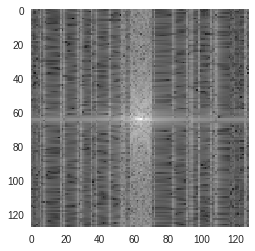

In [15]:
utils.plot.imshowfft(fft)

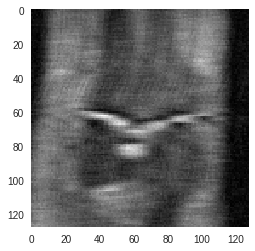

In [16]:
utils.plot.imshowgray(target_image)

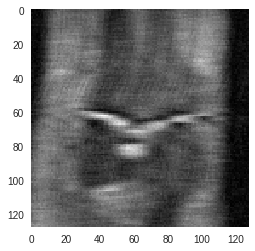

In [17]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


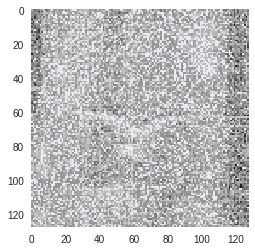

In [18]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [19]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [20]:
# Model most similar to OG AUTOMAP
# def load_uncompiled_automap_model():

#     N = 128
#     X = tf.keras.layers.Input(shape=(N, N, 2))

#     # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
#     # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
#     # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
#     # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

#     ds_flat = tf.keras.layers.Flatten()(X)

# #     fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
# #     fc1 = tf.keras.layers.Dropout(0.05)(fc1)
#     fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(ds_flat)

#     fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

#     conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
#     # L1 regularization to encourage sparsity
#     conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
#                                    activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [21]:
# def load_uncompiled_automap_model():
    
#     # this one's solid, but I believe we'll need a few hours to train it.
    
#     N = 128
#     F = 32
#     X = tf.keras.layers.Input(shape=(N, N, 2))

# #     Half-assed data augmentation
# #     noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (N, N, 2)

#     # These layers all halve the spatial dimension (but also each output F channels)
#     conv1 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(X)])
#     pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # spatial dim: N / 2
    
#     conv2 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool1)])
#     pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # spatial dim: N / 4
    
#     conv3 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool2)])
#     pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # spatial dim: N / 8
    
#     conv4 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(pool3)])
#     # spatial dim: N / 4
    
#     conv5 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv4)])
#     # spatial dim: N / 2
    
#     conv6 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv5)])
#     # spatial dim: N
    
#     conv7 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(conv6)])
    
#     t_conv8 = tf.keras.layers.Conv2DTranspose(6 * F, 5, strides=1, activation='relu', padding='same',
#                                               # Encourage sparsity in output (MRI images are mostly zeros)
#                                               activity_regularizer=tf.keras.regularizers.l1(1e-6))(conv7)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv8) # spatial dim: 128

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [22]:
def load_uncompiled_automap_model():
    
    # this one's solid, but I believe we'll need a few hours to train it.
    
    N = 128
    F = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Half-assed data augmentation
    noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (256, 256, 256)

    # These layers all halve the spatial dimension (but also each output 256 channels)
    conv1 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(X)
    pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # shape: (128, 128, F)

    conv2 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # shape: (64, 64, F)

    conv3 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # shape: (32, 32, F)

    conv4 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv4) # shape: (16, 16, F)

    conv5 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool4)
    pool5 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv5) # shape: (8, 8, F)

    # A "FC-like" layer for fun before we do upsampling
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(pool5) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(4 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4

    # These transposed convolutions upsample spatial dimension by 2
    t_conv1 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv7) # spatial dim: 8
    t_conv2 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv1) # spatial dim: 16
    t_conv3 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv2) # spatial dim: 32
    t_conv4 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv3) # spatial dim: 64
    t_conv5 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv4) # spatial dim: 128
    
    t_conv6 = tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same',
                                              # Encourage sparsity in output (MRI images are mostly zeros)
                                              activity_regularizer=tf.keras.regularizers.l1(1e-6))(t_conv5)
    
    Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv6) # spatial dim: 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [23]:
def lr_schedule(epoch):
    initial_lr = 2e-4
    if epoch < 10:
        return initial_lr #2e-4
    elif epoch >= 10 and epoch < 30:
        return initial_lr / 2e0 #1e-4
    elif epoch >= 30 and epoch < 40:
        return initial_lr #2e-4
    elif epoch >= 40 and epoch < 50:
        return initial_lr / 2e0 #1e-4
    elif epoch >= 50 and epoch < 60:
        return initial_lr / 4e0 #5e-5
    elif epoch >= 60 and epoch < 80:
        return initial_lr / 2e1 #1e-5
    elif epoch >= 80 and epoch < 90:
        return initial_lr / 2e2 #1e-6
    else:
        return initial_lr / 2e3 #1e-7

In [24]:
def load_compiled_automap_model():
    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [25]:
model = load_compiled_automap_model()

In [128]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     2432      
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 128)       0     

# Training

In [27]:
# Show reconstructions during training

def plot_fft_reconstructions(batch, logs):
    plot_frequency = 2500
    
    if batch % plot_frequency != 0:
        return
    
    for dataset_batch, name in first_batches():
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 5)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=batch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=batch)

In [28]:
# Show activation histograms

def layer_activations(inputs):
    layers = model.layers
    names = [l.name for l in layers]
    input_tensor = layers[0].input
    outputs = [l.output for l in layers]
    
    get_activations = tf.keras.backend.function(input_tensor, outputs)
    activations = get_activations(inputs=inputs)
    
    return list(zip(names, activations))

def plot_activations(batch, logs):
    plot_frequency = 2500
    
    if batch % plot_frequency != 0:
        return

    with file_writer.as_default():
        for dataset_batch, stage in first_batches():
            for layer_name, layer_activation in layer_activations(dataset_batch):
                tf.summary.histogram('{}/activations/{}'.format(layer_name, stage.lower()), layer_activation,
                                    step=batch)


In [29]:
# Clear logs and models if necessary
# !rm -r /home/ubuntu/cs230/logs/
# !rm -r /home/ubuntu/cs230/models

In [30]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [31]:
# Callback for printing the LR at the end of each epoch.

class PrintAndLogLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr.numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_fft_reconstructions)

plot_activations_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_activations)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=2500,
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

set_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = os.path.join('/home/ubuntu/cs230/models/automap_fastmri',
                               datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
                               'cp-{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False,
    # Save every K-batches
    save_freq=500_000)
model.save(checkpoint_path.format(epoch=0))

callbacks = [tensorboard_callback, plot_images_callback, plot_activations_callback,
             set_lr_callback, reduce_lr_callback, PrintAndLogLR(), checkpoint_callback]

### Begin training and open Tensorboard to monitor

In [32]:
training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=150,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/150
      1/Unknown - 9s 9s/step - loss: 0.0841 - mean_PSNR: 11.1226

W0607 00:49:29.186155 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.568418). Check your callbacks.


   2172/Unknown - 122s 56ms/step - loss: 0.0211 - mean_PSNR: 17.7878
Learning rate for epoch 1 is 0.00019999999494757503
2172/2172 [==============================] - 138s 63ms/step - loss: 0.0211 - mean_PSNR: 17.7878 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/150


W0607 00:51:41.255025 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.575857). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:00 - loss: 0.0196 - mean_PSNR: 17.8046

W0607 00:51:41.307886 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.287951). Check your callbacks.


 265/2172 [==>...........................] - ETA: 1:59 - loss: 0.0150 - mean_PSNR: 18.8583

W0607 00:53:51.857223 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.769245). Check your callbacks.


   1/2172 [..............................] - ETA: 1:51:36 - loss: 0.0164 - mean_PSNR: 18.5142

W0607 00:53:51.910762 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.384659). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0114 - mean_PSNR: 19.9892
Learning rate for epoch 3 is 0.00019999999494757503
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0114 - mean_PSNR: 19.9892 - val_loss: 0.0118 - val_mean_PSNR: 19.8397
Epoch 4/150


W0607 00:56:01.577374 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.613749). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:01 - loss: 0.0135 - mean_PSNR: 19.3561

W0607 00:56:01.630009 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.306902). Check your callbacks.


 854/2172 [==========>...................] - ETA: 1:12 - loss: 0.0107 - mean_PSNR: 20.2628

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2170/2172 [============================>.] - ETA: 0s - loss: 0.0093 - mean_PSNR: 20.8670
Learning rate for epoch 6 is 0.00019999999494757503
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0093 - mean_PSNR: 20.8666 - val_loss: 0.0101 - val_mean_PSNR: 20.5149
Epoch 7/150


W0607 01:02:29.936073 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.605006). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:29 - loss: 0.0111 - mean_PSNR: 20.1065

W0607 01:02:29.988018 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.302526). Check your callbacks.


1240/2172 [================>.............] - ETA: 49s - loss: 0.0089 - mean_PSNR: 21.0372

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0083 - mean_PSNR: 21.3541
Learning rate for epoch 9 is 0.00019999999494757503
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0083 - mean_PSNR: 21.3541 - val_loss: 0.0093 - val_mean_PSNR: 20.8722
Epoch 10/150


W0607 01:08:55.442574 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.677105). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:02 - loss: 0.0096 - mean_PSNR: 20.6690

W0607 01:08:55.495108 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.338574). Check your callbacks.


2080/2172 [===========================>..] - ETA: 4s - loss: 0.0080 - mean_PSNR: 21.4732

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0075 - mean_PSNR: 21.7993
Learning rate for epoch 12 is 9.999999747378752e-05
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0075 - mean_PSNR: 21.7993 - val_loss: 0.0087 - val_mean_PSNR: 21.1386
Epoch 13/150


W0607 01:15:21.799381 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.698711). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:53 - loss: 0.0086 - mean_PSNR: 21.0938

W0607 01:15:21.851959 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.349379). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0073 - mean_PSNR: 21.8895
Learning rate for epoch 13 is 9.999999747378752e-05
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0073 - mean_PSNR: 21.8895 - val_loss: 0.0087 - val_mean_PSNR: 21.1643
Epoch 14/150


W0607 01:17:29.585703 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.549781). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:19 - loss: 0.0084 - mean_PSNR: 21.2191

W0607 01:17:29.638526 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.274912). Check your callbacks.


 845/2172 [==========>...................] - ETA: 1:12 - loss: 0.0072 - mean_PSNR: 21.9927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1060
Learning rate for epoch 16 is 9.999999747378752e-05
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0070 - mean_PSNR: 22.1061 - val_loss: 0.0085 - val_mean_PSNR: 21.2529
Epoch 17/150


W0607 01:23:54.681464 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.704294). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:53 - loss: 0.0077 - mean_PSNR: 21.5227

W0607 01:23:54.733966 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.352175). Check your callbacks.


1728/2172 [======================>.......] - ETA: 23s - loss: 0.0069 - mean_PSNR: 22.1787

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.2367
Learning rate for epoch 19 is 2.499999936844688e-05
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0068 - mean_PSNR: 22.2367 - val_loss: 0.0086 - val_mean_PSNR: 21.2171
Epoch 20/150


W0607 01:30:22.572548 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.577843). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:15 - loss: 0.0076 - mean_PSNR: 21.5688

W0607 01:30:22.624483 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.288943). Check your callbacks.


1971/2172 [==========================>...] - ETA: 10s - loss: 0.0067 - mean_PSNR: 22.2854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2170/2172 [============================>.] - ETA: 0s - loss: 0.0065 - mean_PSNR: 22.4033
Learning rate for epoch 22 is 9.999999747378752e-05
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0065 - mean_PSNR: 22.4029 - val_loss: 0.0085 - val_mean_PSNR: 21.2320
Epoch 23/150


W0607 01:36:46.904622 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.672469). Check your callbacks.


   1/2172 [..............................] - ETA: 1:47:53 - loss: 0.0071 - mean_PSNR: 21.8169

W0607 01:36:46.957291 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.336269). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0064 - mean_PSNR: 22.4535
Learning rate for epoch 23 is 2.499999936844688e-05
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0064 - mean_PSNR: 22.4535 - val_loss: 0.0085 - val_mean_PSNR: 21.2564
Epoch 24/150


W0607 01:38:55.444606 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.722855). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:33 - loss: 0.0070 - mean_PSNR: 21.9036

W0607 01:38:55.496456 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.361452). Check your callbacks.


 729/2172 [=========>....................] - ETA: 1:19 - loss: 0.0064 - mean_PSNR: 22.5416

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2170/2172 [============================>.] - ETA: 0s - loss: 0.0064 - mean_PSNR: 22.4917
Learning rate for epoch 26 is 9.999999747378752e-05
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0064 - mean_PSNR: 22.4914 - val_loss: 0.0084 - val_mean_PSNR: 21.3059
Epoch 27/150


W0607 01:45:22.399819 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.632276). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:14 - loss: 0.0067 - mean_PSNR: 22.0617

W0607 01:45:22.451601 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.316163). Check your callbacks.


1579/2172 [====================>.........] - ETA: 31s - loss: 0.0062 - mean_PSNR: 22.6054

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1701/2172 [======================>.......] - ETA: 25s - loss: 0.0061 - mean_PSNR: 22.7147
Epoch 00029: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0029.ckpt
2171/2172 [============================>.] - ETA: 0s - loss: 0.0061 - mean_PSNR: 22.7032
Learning rate for epoch 29 is 9.999999747378752e-05
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0061 - mean_PSNR: 22.7032 - val_loss: 0.0085 - val_mean_PSNR: 21.2519
Epoch 30/150


W0607 01:51:49.178697 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.625079). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:27 - loss: 0.0065 - mean_PSNR: 22.1874

W0607 01:51:49.231349 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.312571). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0061 - mean_PSNR: 22.7305
Learning rate for epoch 30 is 2.499999936844688e-05
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0061 - mean_PSNR: 22.7305 - val_loss: 0.0084 - val_mean_PSNR: 21.3026
Epoch 31/150


W0607 01:53:58.537647 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.744863). Check your callbacks.


   1/2172 [..............................] - ETA: 1:50:15 - loss: 0.0064 - mean_PSNR: 22.2238

W0607 01:53:58.590199 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.372465). Check your callbacks.


 362/2172 [====>.........................] - ETA: 1:49 - loss: 0.0067 - mean_PSNR: 22.2943

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2170/2172 [============================>.] - ETA: 0s - loss: 0.0063 - mean_PSNR: 22.5581
Learning rate for epoch 33 is 0.00019999999494757503
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0063 - mean_PSNR: 22.5576 - val_loss: 0.0087 - val_mean_PSNR: 21.1808
Epoch 34/150


W0607 02:00:26.001311 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.617768). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:45 - loss: 0.0068 - mean_PSNR: 21.9854

W0607 02:00:26.053666 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.308918). Check your callbacks.


1201/2172 [===============>..............] - ETA: 51s - loss: 0.0062 - mean_PSNR: 22.5872

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0062 - mean_PSNR: 22.6242
Learning rate for epoch 36 is 4.999999873689376e-05
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0062 - mean_PSNR: 22.6242 - val_loss: 0.0085 - val_mean_PSNR: 21.2677
Epoch 37/150


W0607 02:06:52.039625 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.728016). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:58 - loss: 0.0066 - mean_PSNR: 22.0933

W0607 02:06:52.092230 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.364031). Check your callbacks.


1388/2172 [==================>...........] - ETA: 41s - loss: 0.0061 - mean_PSNR: 22.7035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0061 - mean_PSNR: 22.7150
Learning rate for epoch 39 is 0.00019999999494757503
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0061 - mean_PSNR: 22.7151 - val_loss: 0.0086 - val_mean_PSNR: 21.2139
Epoch 40/150


W0607 02:13:18.865025 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.705731). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:59 - loss: 0.0065 - mean_PSNR: 22.1633

W0607 02:13:18.917351 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.352888). Check your callbacks.


1994/2172 [==========================>...] - ETA: 9s - loss: 0.0060 - mean_PSNR: 22.7486

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0057 - mean_PSNR: 23.0336
Learning rate for epoch 42 is 9.999999747378752e-05
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0057 - mean_PSNR: 23.0336 - val_loss: 0.0083 - val_mean_PSNR: 21.3687
Epoch 43/150


W0607 02:19:45.182772 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.597716). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:05 - loss: 0.0057 - mean_PSNR: 22.6516

W0607 02:19:45.234756 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.298889). Check your callbacks.


2170/2172 [============================>.] - ETA: 0s - loss: 0.0056 - mean_PSNR: 23.1045
Learning rate for epoch 43 is 2.499999936844688e-05
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0056 - mean_PSNR: 23.1042 - val_loss: 0.0083 - val_mean_PSNR: 21.3641
Epoch 44/150


W0607 02:21:54.760754 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.781740). Check your callbacks.


   1/2172 [..............................] - ETA: 1:51:38 - loss: 0.0056 - mean_PSNR: 22.7394

W0607 02:21:54.813781 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.390904). Check your callbacks.


 381/2172 [====>.........................] - ETA: 1:47 - loss: 0.0055 - mean_PSNR: 23.1921
Epoch 00044: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0044.ckpt
 408/2172 [====>.........................] - ETA: 1:44 - loss: 0.0055 - mean_PSNR: 23.1705

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0055 - mean_PSNR: 23.2148
Learning rate for epoch 46 is 9.999999747378752e-05
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0055 - mean_PSNR: 23.2149 - val_loss: 0.0084 - val_mean_PSNR: 21.3493
Epoch 47/150


W0607 02:28:19.879648 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.739701). Check your callbacks.


   1/2172 [..............................] - ETA: 1:50:22 - loss: 0.0055 - mean_PSNR: 22.8391

W0607 02:28:19.931921 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.369878). Check your callbacks.


1271/2172 [================>.............] - ETA: 48s - loss: 0.0054 - mean_PSNR: 23.2661

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0055 - mean_PSNR: 23.1927
Learning rate for epoch 49 is 2.499999936844688e-05
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0055 - mean_PSNR: 23.1927 - val_loss: 0.0083 - val_mean_PSNR: 21.3690
Epoch 50/150


W0607 02:34:47.815170 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.617982). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:44 - loss: 0.0055 - mean_PSNR: 22.8811

W0607 02:34:47.867093 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.309019). Check your callbacks.


2165/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2755

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.3579
Learning rate for epoch 52 is 4.999999873689376e-05
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0053 - mean_PSNR: 23.3579 - val_loss: 0.0082 - val_mean_PSNR: 21.4030
Epoch 53/150


W0607 02:41:14.299703 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.697168). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:42 - loss: 0.0053 - mean_PSNR: 22.9546

W0607 02:41:14.352076 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.348610). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.4025
Learning rate for epoch 53 is 1.249999968422344e-05
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0053 - mean_PSNR: 23.4025 - val_loss: 0.0083 - val_mean_PSNR: 21.3982
Epoch 54/150


W0607 02:43:23.351728 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.623471). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:29 - loss: 0.0053 - mean_PSNR: 22.9977

W0607 02:43:23.404648 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.311757). Check your callbacks.


 711/2172 [========>.....................] - ETA: 1:21 - loss: 0.0052 - mean_PSNR: 23.5236

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0052 - mean_PSNR: 23.4669
Learning rate for epoch 55 is 1.249999968422344e-05
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0052 - mean_PSNR: 23.4669 - val_loss: 0.0083 - val_mean_PSNR: 21.3909
Epoch 56/150


W0607 02:47:40.918370 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.779455). Check your callbacks.


   1/2172 [..............................] - ETA: 1:52:00 - loss: 0.0052 - mean_PSNR: 23.0594

W0607 02:47:40.970903 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.389761). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0052 - mean_PSNR: 23.4924
Learning rate for epoch 56 is 4.999999873689376e-05
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0052 - mean_PSNR: 23.4924 - val_loss: 0.0083 - val_mean_PSNR: 21.3889
Epoch 57/150


W0607 02:49:50.929105 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.717014). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:26 - loss: 0.0052 - mean_PSNR: 23.0926

W0607 02:49:50.981503 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.358541). Check your callbacks.


 842/2172 [==========>...................] - ETA: 1:13 - loss: 0.0050 - mean_PSNR: 23.6292

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 23.5537
Learning rate for epoch 59 is 1.249999968422344e-05
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0051 - mean_PSNR: 23.5537 - val_loss: 0.0083 - val_mean_PSNR: 21.3805
Epoch 60/150


W0607 02:56:15.380089 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.712873). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:08 - loss: 0.0051 - mean_PSNR: 23.1743

W0607 02:56:15.431772 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.356458). Check your callbacks.


1639/2172 [=====================>........] - ETA: 28s - loss: 0.0051 - mean_PSNR: 23.5841

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 23.5384
Learning rate for epoch 62 is 9.999999747378752e-06
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0051 - mean_PSNR: 23.5384 - val_loss: 0.0083 - val_mean_PSNR: 21.4128
Epoch 63/150


W0607 03:02:43.050676 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.587770). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:49 - loss: 0.0051 - mean_PSNR: 23.1873

W0607 03:02:43.103070 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.293923). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 23.5553
Learning rate for epoch 63 is 2.499999936844688e-06
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0051 - mean_PSNR: 23.5553 - val_loss: 0.0083 - val_mean_PSNR: 21.4124
Epoch 64/150


W0607 03:04:52.384334 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.562950). Check your callbacks.


   1/2172 [..............................] - ETA: 1:43:47 - loss: 0.0050 - mean_PSNR: 23.2086

W0607 03:04:52.437052 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.281504). Check your callbacks.


 380/2172 [====>.........................] - ETA: 1:46 - loss: 0.0051 - mean_PSNR: 23.6163

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 23.5905
Learning rate for epoch 66 is 9.999999747378752e-06
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0051 - mean_PSNR: 23.5905 - val_loss: 0.0083 - val_mean_PSNR: 21.4100
Epoch 67/150


W0607 03:11:18.894600 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.702756). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:09 - loss: 0.0050 - mean_PSNR: 23.2530

W0607 03:11:18.947047 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.351399). Check your callbacks.


1290/2172 [================>.............] - ETA: 46s - loss: 0.0050 - mean_PSNR: 23.6357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6164
Learning rate for epoch 69 is 2.499999936844688e-06
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0050 - mean_PSNR: 23.6164 - val_loss: 0.0083 - val_mean_PSNR: 21.4078
Epoch 70/150


W0607 03:17:44.760465 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.621362). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:02 - loss: 0.0050 - mean_PSNR: 23.2897

W0607 03:17:44.813170 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.310716). Check your callbacks.


2169/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6244

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6448
Learning rate for epoch 73 is 2.499999936844688e-06
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0050 - mean_PSNR: 23.6447 - val_loss: 0.0083 - val_mean_PSNR: 21.4037
Epoch 74/150


W0607 03:26:16.884094 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.810694). Check your callbacks.


   1/2172 [..............................] - ETA: 1:52:46 - loss: 0.0049 - mean_PSNR: 23.3273

W0607 03:26:16.936455 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.405380). Check your callbacks.


 865/2172 [==========>...................] - ETA: 1:11 - loss: 0.0049 - mean_PSNR: 23.7578

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6632
Learning rate for epoch 76 is 9.999999747378752e-06
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0050 - mean_PSNR: 23.6632 - val_loss: 0.0083 - val_mean_PSNR: 21.4004
Epoch 77/150


W0607 03:32:42.201000 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.623109). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:07 - loss: 0.0049 - mean_PSNR: 23.3522

W0607 03:32:42.253612 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.311588). Check your callbacks.


1648/2172 [=====================>........] - ETA: 27s - loss: 0.0050 - mean_PSNR: 23.6792

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6799
Learning rate for epoch 79 is 2.499999936844688e-06
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0050 - mean_PSNR: 23.6799 - val_loss: 0.0083 - val_mean_PSNR: 21.3972
Epoch 80/150


W0607 03:39:05.232578 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.596391). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:04 - loss: 0.0049 - mean_PSNR: 23.3718

W0607 03:39:05.284614 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.298217). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0050 - mean_PSNR: 23.6853
Learning rate for epoch 80 is 9.999999747378752e-06
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0050 - mean_PSNR: 23.6852 - val_loss: 0.0083 - val_mean_PSNR: 21.3961
Epoch 81/150


W0607 03:41:15.133048 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.848748). Check your callbacks.


   1/2172 [..............................] - ETA: 1:54:05 - loss: 0.0049 - mean_PSNR: 23.3776

W0607 03:41:15.185739 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.424398). Check your callbacks.


 345/2172 [===>..........................] - ETA: 1:50 - loss: 0.0051 - mean_PSNR: 23.5712

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0052 - mean_PSNR: 23.4617
Learning rate for epoch 82 is 9.999999974752427e-07
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0052 - mean_PSNR: 23.4617 - val_loss: 0.0082 - val_mean_PSNR: 21.4653
Epoch 83/150


W0607 03:45:32.492939 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.712196). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:25 - loss: 0.0051 - mean_PSNR: 23.1873

W0607 03:45:32.544990 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.356121). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0052 - mean_PSNR: 23.4628
Learning rate for epoch 83 is 9.999999974752427e-07
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0052 - mean_PSNR: 23.4627 - val_loss: 0.0081 - val_mean_PSNR: 21.4672
Epoch 84/150


W0607 03:47:41.665726 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.609648). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:25 - loss: 0.0051 - mean_PSNR: 23.1925

W0607 03:47:41.718456 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.304856). Check your callbacks.


 418/2172 [====>.........................] - ETA: 1:42 - loss: 0.0052 - mean_PSNR: 23.4700

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0052 - mean_PSNR: 23.4858
Learning rate for epoch 86 is 2.499999993688107e-07
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0052 - mean_PSNR: 23.4857 - val_loss: 0.0082 - val_mean_PSNR: 21.4649
Epoch 87/150


W0607 03:54:07.196881 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.867508). Check your callbacks.


   1/2172 [..............................] - ETA: 1:54:59 - loss: 0.0050 - mean_PSNR: 23.2183

W0607 03:54:07.250036 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.433789). Check your callbacks.


 763/2172 [=========>....................] - ETA: 1:19 - loss: 0.0051 - mean_PSNR: 23.5869
Epoch 00087: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0087.ckpt
1272/2172 [================>.............] - ETA: 49s - loss: 0.0051 - mean_PSNR: 23.5358

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 23.5041
Learning rate for epoch 89 is 9.999999974752427e-07
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0051 - mean_PSNR: 23.5041 - val_loss: 0.0082 - val_mean_PSNR: 21.4619
Epoch 90/150


W0607 04:00:35.347689 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.680728). Check your callbacks.


   1/2172 [..............................] - ETA: 1:48:21 - loss: 0.0050 - mean_PSNR: 23.2399

W0607 04:00:35.400023 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.340385). Check your callbacks.


2085/2172 [===========================>..] - ETA: 4s - loss: 0.0052 - mean_PSNR: 23.4927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2288
Learning rate for epoch 92 is 1.0000000116860974e-07
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2288 - val_loss: 0.0080 - val_mean_PSNR: 21.5526
Epoch 93/150


W0607 04:07:00.472102 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.589050). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:28 - loss: 0.0052 - mean_PSNR: 23.0971

W0607 04:07:00.524421 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.294557). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2546
Learning rate for epoch 93 is 2.5000000292152436e-08
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0054 - mean_PSNR: 23.2545 - val_loss: 0.0080 - val_mean_PSNR: 21.5596
Epoch 94/150


W0607 04:09:10.088368 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.742367). Check your callbacks.


   1/2172 [..............................] - ETA: 1:50:31 - loss: 0.0052 - mean_PSNR: 23.0428

W0607 04:09:10.140026 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.371206). Check your callbacks.


 748/2172 [=========>....................] - ETA: 1:18 - loss: 0.0053 - mean_PSNR: 23.3538

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2737
Learning rate for epoch 96 is 1.0000000116860974e-07
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2736 - val_loss: 0.0080 - val_mean_PSNR: 21.5669
Epoch 97/150


W0607 04:15:34.056226 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.556688). Check your callbacks.


   1/2172 [..............................] - ETA: 1:43:48 - loss: 0.0053 - mean_PSNR: 22.9864

W0607 04:15:34.108757 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.278365). Check your callbacks.


1612/2172 [=====================>........] - ETA: 29s - loss: 0.0054 - mean_PSNR: 23.2951

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2788
Learning rate for epoch 99 is 2.5000000292152436e-08
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2787 - val_loss: 0.0080 - val_mean_PSNR: 21.5693
Epoch 100/150


W0607 04:21:58.624508 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.573895). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:00 - loss: 0.0053 - mean_PSNR: 22.9779

W0607 04:21:58.676398 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.286968). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2799
Learning rate for epoch 100 is 1.0000000116860974e-07
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2798 - val_loss: 0.0080 - val_mean_PSNR: 21.5697
Epoch 101/150


W0607 04:24:07.088312 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.726119). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:40 - loss: 0.0053 - mean_PSNR: 22.9773

W0607 04:24:07.140810 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.363092). Check your callbacks.


 340/2172 [===>..........................] - ETA: 1:49 - loss: 0.0053 - mean_PSNR: 23.3457

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2829
Learning rate for epoch 103 is 2.5000000292152436e-08
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2828 - val_loss: 0.0080 - val_mean_PSNR: 21.5709
Epoch 104/150


W0607 04:30:30.748770 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.589909). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:39 - loss: 0.0053 - mean_PSNR: 22.9775

W0607 04:30:30.800629 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.294976). Check your callbacks.


1196/2172 [===============>..............] - ETA: 52s - loss: 0.0054 - mean_PSNR: 23.3153

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2854
Learning rate for epoch 106 is 1.0000000116860974e-07
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2853 - val_loss: 0.0080 - val_mean_PSNR: 21.5716
Epoch 107/150


W0607 04:36:55.699399 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.606106). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:16 - loss: 0.0053 - mean_PSNR: 22.9786

W0607 04:36:55.751607 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.303087). Check your callbacks.


2080/2172 [===========================>..] - ETA: 4s - loss: 0.0054 - mean_PSNR: 23.2759

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2877
Learning rate for epoch 109 is 2.5000000292152436e-08
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2876 - val_loss: 0.0079 - val_mean_PSNR: 21.5723
Epoch 110/150


W0607 04:43:22.102746 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.716036). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:50 - loss: 0.0053 - mean_PSNR: 22.9800

W0607 04:43:22.154645 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.358040). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2884
Learning rate for epoch 110 is 1.0000000116860974e-07
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2883 - val_loss: 0.0079 - val_mean_PSNR: 21.5725
Epoch 111/150


W0607 04:45:29.261362 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.568837). Check your callbacks.


   1/2172 [..............................] - ETA: 1:43:54 - loss: 0.0053 - mean_PSNR: 22.9805

W0607 04:45:29.313275 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.284442). Check your callbacks.


 786/2172 [=========>....................] - ETA: 1:15 - loss: 0.0053 - mean_PSNR: 23.4099

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2904
Learning rate for epoch 113 is 2.5000000292152436e-08
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2903 - val_loss: 0.0079 - val_mean_PSNR: 21.5730
Epoch 114/150


W0607 04:51:55.060692 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.718636). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:19 - loss: 0.0053 - mean_PSNR: 22.9820

W0607 04:51:55.112635 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.359339). Check your callbacks.


1531/2172 [====================>.........] - ETA: 34s - loss: 0.0053 - mean_PSNR: 23.3338

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2924
Learning rate for epoch 116 is 1.0000000116860974e-07
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2923 - val_loss: 0.0079 - val_mean_PSNR: 21.5734
Epoch 117/150


W0607 04:58:22.566453 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.729220). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:50 - loss: 0.0053 - mean_PSNR: 22.9837

W0607 04:58:22.618877 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.364631). Check your callbacks.


1185/2172 [===============>..............] - ETA: 52s - loss: 0.0053 - mean_PSNR: 23.3267

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2942
Learning rate for epoch 119 is 2.5000000292152436e-08
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0054 - mean_PSNR: 23.2941 - val_loss: 0.0079 - val_mean_PSNR: 21.5738
Epoch 120/150


W0607 05:04:48.457761 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.585176). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:32 - loss: 0.0053 - mean_PSNR: 22.9853

W0607 05:04:48.509427 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.292610). Check your callbacks.


1988/2172 [==========================>...] - ETA: 9s - loss: 0.0054 - mean_PSNR: 23.2842

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2960
Learning rate for epoch 122 is 1.0000000116860974e-07
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2959 - val_loss: 0.0079 - val_mean_PSNR: 21.5741
Epoch 123/150


W0607 05:11:12.867676 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.616104). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:02 - loss: 0.0053 - mean_PSNR: 22.9870

W0607 05:11:12.919571 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.308074). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2965
Learning rate for epoch 123 is 2.5000000292152436e-08
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2964 - val_loss: 0.0079 - val_mean_PSNR: 21.5742
Epoch 124/150


W0607 05:13:20.135257 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.714615). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:23 - loss: 0.0053 - mean_PSNR: 22.9875

W0607 05:13:20.187368 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.357331). Check your callbacks.


 725/2172 [=========>....................] - ETA: 1:19 - loss: 0.0053 - mean_PSNR: 23.4063

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2982
Learning rate for epoch 126 is 1.0000000116860974e-07
2172/2172 [==============================] - 129s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2981 - val_loss: 0.0079 - val_mean_PSNR: 21.5745
Epoch 127/150


W0607 05:19:45.265874 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.585016). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:40 - loss: 0.0053 - mean_PSNR: 22.9892

W0607 05:19:45.318196 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.292529). Check your callbacks.


1567/2172 [====================>.........] - ETA: 32s - loss: 0.0053 - mean_PSNR: 23.3380

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.2998
Learning rate for epoch 129 is 2.5000000292152436e-08
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.2997 - val_loss: 0.0079 - val_mean_PSNR: 21.5748
Epoch 130/150


W0607 05:26:09.629449 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.665324). Check your callbacks.


   1/2172 [..............................] - ETA: 1:47:22 - loss: 0.0053 - mean_PSNR: 22.9908

W0607 05:26:09.681333 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.332684). Check your callbacks.


1145/2172 [==============>...............] - ETA: 54s - loss: 0.0053 - mean_PSNR: 23.3372
Epoch 00130: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0130.ckpt
2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3003
Learning rate for epoch 130 is 1.0000000116860974e-07
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.3002 - val_loss: 0.0079 - val_mean_PSNR: 21.5749
Epoch 131/150


W0607 05:28:17.191335 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.587076). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:52 - loss: 0.0053 - mean_PSNR: 22.9913

W0607 05:28:17.243615 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.293559). Check your callbacks.


 210/2172 [=>............................] - ETA: 2:06 - loss: 0.0052 - mean_PSNR: 23.4471

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3018
Learning rate for epoch 133 is 2.5000000292152436e-08
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.3018 - val_loss: 0.0079 - val_mean_PSNR: 21.5751
Epoch 134/150


W0607 05:34:42.241445 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.622220). Check your callbacks.


   1/2172 [..............................] - ETA: 1:46:08 - loss: 0.0053 - mean_PSNR: 22.9929

W0607 05:34:42.294300 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.311143). Check your callbacks.


1063/2172 [=============>................] - ETA: 1:00 - loss: 0.0053 - mean_PSNR: 23.3603

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3034
Learning rate for epoch 136 is 1.0000000116860974e-07
2172/2172 [==============================] - 127s 59ms/step - loss: 0.0054 - mean_PSNR: 23.3033 - val_loss: 0.0079 - val_mean_PSNR: 21.5753
Epoch 137/150


W0607 05:41:06.345868 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.713358). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:11 - loss: 0.0053 - mean_PSNR: 22.9944

W0607 05:41:06.397733 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.356704). Check your callbacks.


1894/2172 [=========================>....] - ETA: 14s - loss: 0.0054 - mean_PSNR: 23.2976

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3049
Learning rate for epoch 139 is 2.5000000292152436e-08
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0054 - mean_PSNR: 23.3048 - val_loss: 0.0079 - val_mean_PSNR: 21.5755
Epoch 140/150


W0607 05:47:34.528435 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.607107). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:34 - loss: 0.0053 - mean_PSNR: 22.9958

W0607 05:47:34.580827 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.303588). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3054
Learning rate for epoch 140 is 1.0000000116860974e-07
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0054 - mean_PSNR: 23.3053 - val_loss: 0.0079 - val_mean_PSNR: 21.5755
Epoch 141/150


W0607 05:49:43.810968 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.577659). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:41 - loss: 0.0053 - mean_PSNR: 22.9963

W0607 05:49:43.862746 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.288853). Check your callbacks.


 551/2172 [======>.......................] - ETA: 1:31 - loss: 0.0053 - mean_PSNR: 23.3428

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2170/2172 [============================>.] - ETA: 0s - loss: 0.0054 - mean_PSNR: 23.3071
Learning rate for epoch 143 is 2.5000000292152436e-08
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0054 - mean_PSNR: 23.3067 - val_loss: 0.0079 - val_mean_PSNR: 21.5757
Epoch 144/150


W0607 05:56:08.152731 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.712068). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:31 - loss: 0.0053 - mean_PSNR: 22.9978

W0607 05:56:08.205318 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.356057). Check your callbacks.


1360/2172 [=================>............] - ETA: 43s - loss: 0.0053 - mean_PSNR: 23.3537

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.3082
Learning rate for epoch 146 is 1.0000000116860974e-07
2172/2172 [==============================] - 130s 60ms/step - loss: 0.0053 - mean_PSNR: 23.3081 - val_loss: 0.0079 - val_mean_PSNR: 21.5758
Epoch 147/150


W0607 06:02:34.894683 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.624933). Check your callbacks.


   1/2172 [..............................] - ETA: 1:45:59 - loss: 0.0053 - mean_PSNR: 22.9992

W0607 06:02:34.947336 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.312492). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.3086
Learning rate for epoch 147 is 2.5000000292152436e-08
2172/2172 [==============================] - 129s 60ms/step - loss: 0.0053 - mean_PSNR: 23.3085 - val_loss: 0.0079 - val_mean_PSNR: 21.5759
Epoch 148/150


W0607 06:04:44.400318 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.680983). Check your callbacks.


   1/2172 [..............................] - ETA: 1:49:14 - loss: 0.0053 - mean_PSNR: 22.9997

W0607 06:04:44.452497 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.340521). Check your callbacks.


  29/2172 [..............................] - ETA: 5:29 - loss: 0.0051 - mean_PSNR: 23.5689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.3095
Learning rate for epoch 149 is 2.5000000292152436e-08
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0053 - mean_PSNR: 23.3094 - val_loss: 0.0079 - val_mean_PSNR: 21.5760
Epoch 150/150


W0607 06:09:00.474165 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.588796). Check your callbacks.


   1/2172 [..............................] - ETA: 1:44:45 - loss: 0.0053 - mean_PSNR: 23.0007

W0607 06:09:00.526476 140152698894080 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.294421). Check your callbacks.


2171/2172 [============================>.] - ETA: 0s - loss: 0.0053 - mean_PSNR: 23.3100
Learning rate for epoch 150 is 1.0000000116860974e-07
2172/2172 [==============================] - 128s 59ms/step - loss: 0.0053 - mean_PSNR: 23.3099 - val_loss: 0.0079 - val_mean_PSNR: 21.5760


### Save model (to do: make callback)

In [33]:
# # # Uncomment to save model
saved_model_path = checkpoint_dir + '-saved-model'
model.save(saved_model_path)

## Evaluate model

In [264]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

    488/Unknown - 7s 15ms/step - loss: 0.0099 - mean_PSNR: 20.9047

[0.009910383691140985, 20.904732]

### Plot training history (but better viewed in Tensorboard)

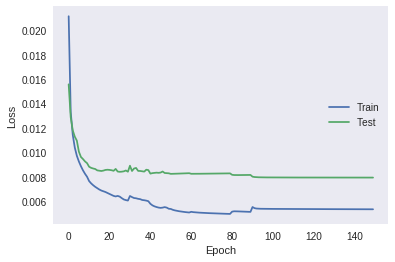

In [35]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

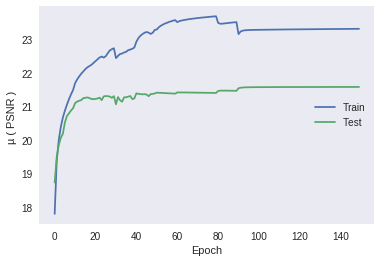

In [36]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

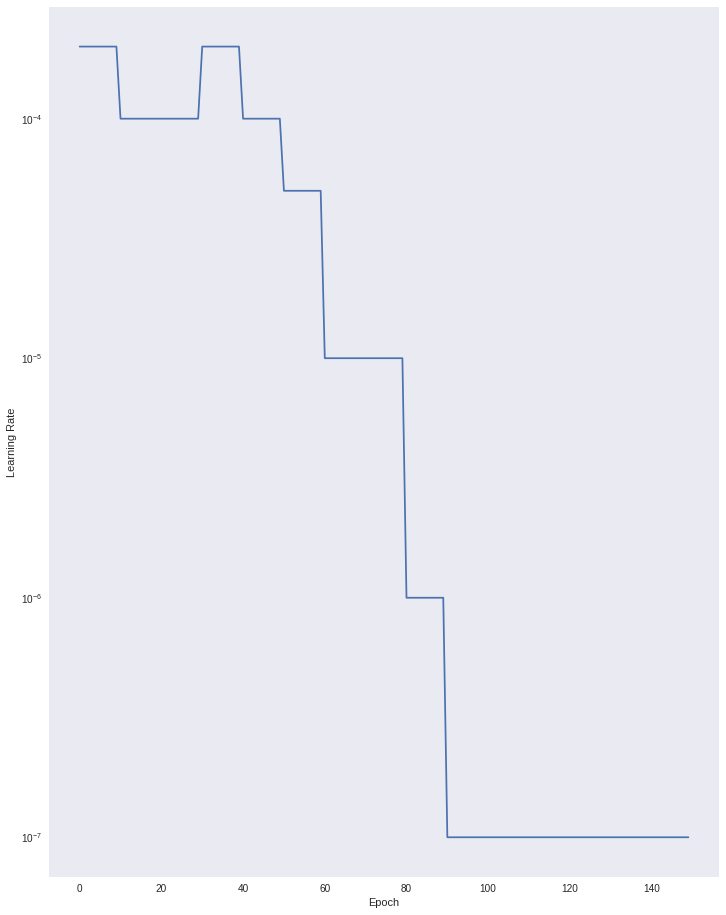

In [92]:
plt.figure()
plt.plot(training_history.history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')

In [338]:
# Predict on a test batch

def predict_and_visualize(model, x, y):

    # Run model
    y_pred = model.predict(x)

    # Inspect output
    for i in range(len(x)):

        fft = utils.fastmri._combine_two_channels_of_complex_tensor(x[i]).numpy()
        fft_mag = np.abs(fft)
        fft_ang = np.angle(fft)
        reconstruction = y_pred[i, ..., 0]
        image = y[i, ..., 0]

        MSE = utils.signal_processing.mean_square_error(reconstruction, image)
        PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

        plt.subplot(2, 2, 1)
        plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
        utils.plot.imshowgray(reconstruction)

        plt.subplot(2, 2, 2)
        plt.title('FFT (Magnitude)')
        utils.plot.imshowfft(fft_mag)

        plt.subplot(2, 2, 3)
        plt.title('Expected reconstruction')
        utils.plot.imshowgray(image)

        plt.subplot(2, 2, 4)
        plt.title('FFT (Phase)')
        utils.plot.imshowgray(fft_ang)

        plt.show()
        break
        
    print('For validation: x.sum()={}, y.sum()={}, y_pred.sum()={}'.format(x.sum(), y.sum(), y_pred.sum()))
    print('Model iterations: {}'.format(model.optimizer.iterations.numpy()))
        
    # Return model output
    return y_pred

# Load a saved model

def restore_model(restore_path, weights_only, model=None, custom_objects=None):
    '''
    Restoring saved models
    
    - To restore a `tf.keras.Model` saved with `model.save_weights(...)`:
        Set `weights_only` to `True`. Restore weights at `restore_path` into `model`.
    - To restore a `tf.keras.Model` saved with `model.save(...)`:
        Set `weights_only` to `False`. Load and return and entire model at `restore_path`,
        optionally passing in the dictionary `custom_objects`.
    '''
    if weights_only:
        assert model is not None, 'Must pass a model if only restoring weights.'
        model.load_weights(restore_path)
    else:
        assert model is None, 'Do not pass a model if only restoring weights. A model will be returned.'
        model = tf.keras.models.load_model(restore_path, custom_objects=custom_objects)

    return model



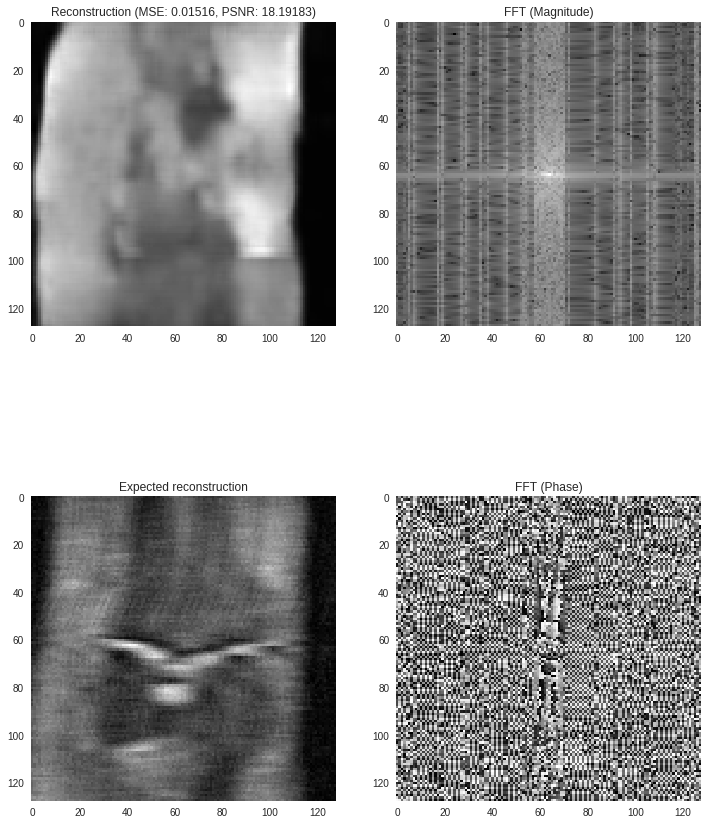

For validation: x.sum()=133.75682067871094, y.sum()=36231.1953125, y_pred.sum()=34883.23828125
Model iterations: 325800


In [344]:
# Predict on a test batch

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
predict_and_visualize(model, x, y);

# Restore and run saved model

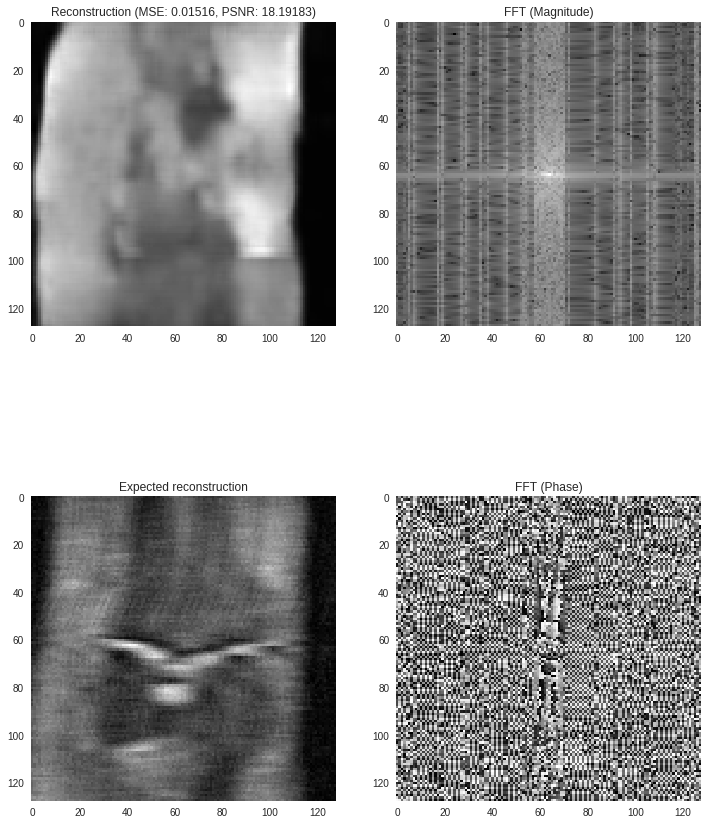

For validation: x.sum()=133.75682067871094, y.sum()=36231.1953125, y_pred.sum()=34883.23828125
Model iterations: 325800


In [345]:
saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'
restored_model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
predict_and_visualize(restored_model, x, y);